In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import imageio

from skimage.transform import rescale, resize, rotate
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, auc, accuracy_score
from sklearn.model_selection import train_test_split

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras import callbacks
from keras.models import load_model

from image_handler import ImageHandler

In [281]:
data = pd.read_csv('../datasets/annotated_honeybee/bee_data.csv')
data.shape

(5172, 9)

In [282]:
health_counts = data["health"].value_counts()
health_counts

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [283]:
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
target_categories

['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles']

In [284]:
data = data[[status in target_categories for status in data["health"]]]
data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
74,017_029.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
75,017_015.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
76,017_001.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
77,017_000.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
78,017_014.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [285]:
data["has_varroa"] = (data["health"] != "healthy").astype(int)
data["has_varroa"].head()

74    0
75    0
76    0
77    0
78    0
Name: has_varroa, dtype: int64

In [286]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

In [287]:
data.shape

(4435, 10)

In [288]:
data = data[["file","has_varroa"]]
data.head()

,file,has_varroa
74,017_029.png,0
75,017_015.png,0
76,017_001.png,0
77,017_000.png,0
78,017_014.png,0


In [289]:
data.shape

(4435, 2)

In [290]:
health_counts = data["has_varroa"].value_counts()
health_counts # 0: healthy; 1: has_varroa

0    3384
1    1051
Name: has_varroa, dtype: int64

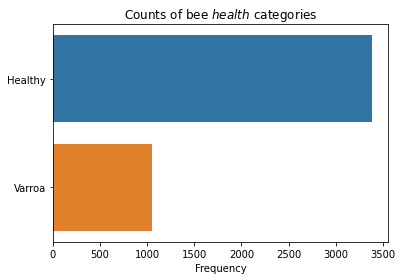

In [291]:
plt.title("Counts of bee $health$ categories")
g = sns.barplot(x = health_counts, y = health_counts.index, orient="h");
plt.yticks([0,1],["Healthy","Varroa"])
g.set_xlabel("Frequency");

In [292]:
def get_image_data(files):
    IMAGE_FILE_ROOT = '../datasets/annotated_honeybee/bee_imgs/' 
    return np.asanyarray([imageio.imread("{}{}".format(IMAGE_FILE_ROOT, file)) for file in files])

In [293]:
def show_image(image, ax = plt, title = None, show_size = False):
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

In [294]:
def show_images(files, titles = None, show_size = False):
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(files)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, file in enumerate(files):
        if titles:
            show_image(file, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(file, ax = ax[i], title = None, show_size = show_size)
    plt.show()

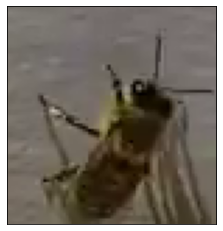

In [295]:
raw_images = get_image_data(data["file"].values)
show_image(raw_images[0])

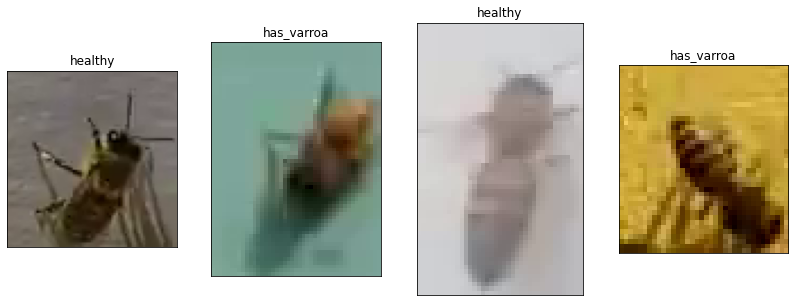

In [296]:
show_images(raw_images[::1200], list(data["has_varroa"].map({1: "has_varroa", 0: "healthy"})[::1200]))

In [297]:
def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the give images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

In [298]:
def get_best_average(dist, cutoff = .5):
    '''Returns an integer of the average from the given distribution above the cutoff.'''
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [299]:
wh = get_images_wh(raw_images)

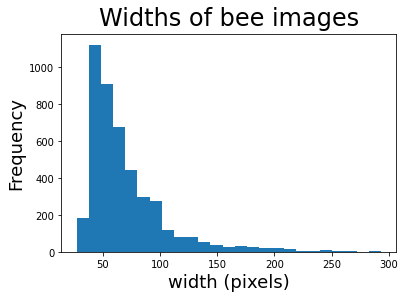

In [300]:
size = 18
plt.title("Widths of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[0], bins = 25);

In [301]:
IDEAL_WIDTH, IDEAL_HEIGHT = get_best_average(wh[0]), get_best_average(wh[1])
IDEAL_WIDTH, IDEAL_HEIGHT

(54, 50)

In [302]:
resizing = (IDEAL_WIDTH, IDEAL_HEIGHT, 3)

sample_img_store = ImageHandler(raw_images[:201]).resize(resizing)

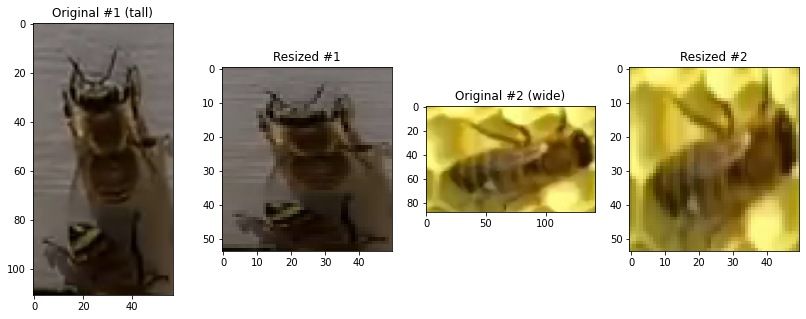

In [303]:
old_image_1 = raw_images[100]
new_image_1 = sample_img_store.images_for_display[100]

old_image_2 = raw_images[200]
new_image_2 = sample_img_store.images_for_display[200]
show_images(
    [old_image_1, new_image_1, old_image_2, new_image_2], 
    titles = ["Original #1 (tall)", "Resized #1", "Original #2 (wide)", "Resized #2"], 
    show_size = True
)

In [304]:
kernel_size = 3
dropout = .5
batch_size = 54 #100 # 54 previously
activation_func = "relu"
input_shape = (batch_size, 50, 3)

conv__filters_1 = 32
conv__filters_2 = 48
conv__filters_3 = 64
density_units_1 = 256
density_units_2 = 64
epochs          = 10 # 50

In [305]:
def normalize(image):
    '''
    Returns the given np.array image rescaled and normalized to be between -.5 and .5
    
    Source: https://www.jeremyjordan.me/batch-normalization/
    '''
    return (image/255. - 0.5)

In [306]:
def create_datagens(
    data, datagen_params, 
    target_shape, batch_size, x_col="file", y_col="has_varroa", IMAGE_FILE_ROOT = '../annotated-honeybee-dataset/bee_imgs/', 
    random_state = None, preprocessing_function = None):
        '''
        Appropriately creates and returns two ImageDataGenerator objects - one for training and one for testing.
        
        ImageDataGenerator objects are responsible for handling image data during model training, by pulling the data
        directly from the image data directory, resizing the image, and applying the appropriate transformations.
        
        The testing ImageDataGenerator object does not apply any transformations.
        '''
        data[y_col] = data[y_col].astype(str) # coercion needed for datagen
        # train/test split
        train, test = train_test_split(
            data, 
            test_size = 2/3, 
            stratify = data.iloc[:,-1], # assumed last column is target variable
            random_state = random_state
            )
        
        # training ImageDataGenerator
        datagen = ImageDataGenerator(
            horizontal_flip  = datagen_params.get("horizontal_flip") or False, 
            vertical_flip    = datagen_params.get("vertical_flip") or False, 
            rotation_range   = datagen_params.get("rotation_range") or False,
            brightness_range = datagen_params.get("brightness_range"),
            preprocessing_function = preprocessing_function
        )

        datagen_iter_train = datagen.flow_from_dataframe(
            train, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = batch_size, 
            shuffle     = True,
            seed        = random_state
        )

        # testing ImageDataGenerator
        datagen_test = ImageDataGenerator(preprocessing_function = preprocessing_function)

        datagen_iter_test = datagen_test.flow_from_dataframe(
            test, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = 1, 
            shuffle     = False
        )
        
        return datagen_iter_train, datagen_iter_test

In [307]:
def permutate_params(grid_params):
    '''Returns a list of all combinations of unique parameters from the given dictionary'''
    out = [{}]
    
    # loop through each key/val pair
    for param_name, param_list in grid_params.items():
        # shortcircut - no need to permute single items
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            # for each item in the param, clone entire growing list and add param to each
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

In [308]:
def build_model_from_datagen(
    params = dict(), 
    input_shape = (), 
    datagen_iter_train = None, 
    datagen_iter_val = None, 
    optimizer = "adam",
    file_name = None
):
    '''Returns a fitted convolutional neural network with the given parameters and data.'''
    kernel_size = 3
    dropout = .5
    activation_func = "relu"

    conv__filters_1 = params.get('conv__filters_1') or 32
    conv__filters_2 = params.get('conv__filters_2') or 16
    conv__filters_3 = params.get('conv__filters_3') or 32
    density_units_1 = params.get('density_units_1') or 32
    density_units_2 = params.get('density_units_2') or 32
    epochs          = params.get('epochs') or 8
    
    # instantiating model
    model = Sequential([
        # Conv layer #1
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size + 4, 
            activation  = activation_func, 
            input_shape = input_shape, #input layer
            padding     = "same"
        ),
        Conv2D(filters = conv__filters_1, kernel_size = kernel_size + 4, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #2
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #3
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Dense layer #1
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        
        # Dense layer #2
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # compiling model
    model.compile(
        loss      = 'binary_crossentropy',
        optimizer = optimizer,
        metrics   = ['binary_accuracy']
    )
    
    # fitting model w/ImageDataGenerator
    STEP_SIZE_TRAIN= np.ceil(datagen_iter_train.n/datagen_iter_train.batch_size)
    STEP_SIZE_VALID= np.ceil(datagen_iter_val.n/datagen_iter_val.batch_size)

    # NOTE: the best model is saved to disk via callbacks, and is a retrievable file
    history = model.fit_generator(
        generator           = datagen_iter_train,
        steps_per_epoch     = STEP_SIZE_TRAIN,
        validation_data     = datagen_iter_val,
        validation_steps    = STEP_SIZE_VALID,
        epochs              = epochs,
        callbacks           = [callbacks.ModelCheckpoint(file_name, save_best_only=True, mode='auto', save_freq='epoch')]
    )
#     history = model.fit(datagen_iter_train, y_train, epochs=epochs)
    
    return (model, history)

In [309]:
def gridSearchCNN(
    datagens,
    grid_params, 
    file_name,
    optimizer = "adam",
    random_state = None,
):
    '''
    Iteratively discovers and then returns an optimized convolutional neural network with the given grid_params
    
    Much of the code related to datagen came from:
    https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
    '''
    # list of all parameter combinations
    all_params = permutate_params(grid_params) 
    
    # establishing variables
    best_model   = None
    best_score   = 0.0 # no accuracy to start
    best_params  = None
    best_history = None
    test_scores  = None
    train_scores = None
    
    datagen_iter_train, datagen_iter_test = datagens
    
    # for each permuted parameter, try fitting a model (NOTE: the best model is saved to disk with file_name)
    for params in all_params:
        model, history = build_model_from_datagen(
            params, 
            input_shape        = datagen_iter_train.image_shape,
            datagen_iter_train = datagen_iter_train,
            datagen_iter_val   = datagen_iter_test,
            optimizer          = optimizer,
            file_name          = file_name
        )

        acc = max(history.history["val_binary_accuracy"])
        
        # only keeping best
        if acc > best_score:
            print("***Good Accurary found: {:.2%}***".format(acc))
            best_score   = acc
            test_scores  = history.history["val_binary_accuracy"]
            train_scores = history.history["binary_accuracy"]
            best_model   = model
            best_params  = params
            best_history = history
    
    # returns metadata of results (NOTE: retrieving best model from hard disk)
    return {
        "best_model"   : load_model(file_name),
        "best_score"   : best_score,
        "best_params"  : best_params,
        "best_history" : best_history,
        "test_scores"  : test_scores,
        "train_scores" : train_scores
    }

In [310]:
def conf_matrix_stats(y_test, preds):
    ''' Return key confusion matrix metrics given true and predicted values'''
    cm = confusion_matrix(y_test, preds)
    TP, FP, FN, TN, = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    total = (TP + FP + FN + TN)
    acc = (TP + TN ) / total
    miss = 1 - acc
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    return {"accuracy": acc, "miss_rate": miss, "sensitivity": sens, "specification": spec, "precision": prec}

In [311]:
def graph_loss(history):
    '''
    Graphs the training and testing loss using the given History object from model training
    
    Note: this function was modified from code provided by Riley Dallas (General Assembly instructor - 11.04-lesson-cnn)
    '''
    # Check out our train loss and test loss over epochs.
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    xticks = np.array(range(len(train_loss)))
    # Set figure size.
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs.
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Binary Crossentropy', fontsize = 18)
    plt.xticks(xticks[::5], (xticks+1)[::5])

    plt.legend(fontsize = 18);

In [312]:
def show_results(images, shapes, title, ncols = 4, height = 2, width = 2):
    '''Plots list of given images'''
    nrows = int(np.ceil(len(images)/ncols))
    f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols * width, nrows * height))
    ax = ax.flatten() if type(ax) == np.ndarray else ax
    i = None
    for i, image in enumerate(images):
        _title = f"Orig. size: {shapes[i][0]}x{shapes[i][1]}\n{title} #{i+1}"
        show_image(image, ax = ax[i] if type(ax) == np.ndarray else ax, title = _title)
    
    # removing extraneous subplots
    while i and type(ax) == np.ndarray and i < len(ax) - 1:
        i += 1
        f.delaxes(ax[i])

In [313]:
# For reproducibility
random_state = 42
np.random.seed(random_state)

In [314]:
MODEL_PATH = "../models/"
model_name = "varroa_detection_v100"
stored_model_path = f"{MODEL_PATH}/{model_name}.p"

# MODEL_PATH = "./"
# model_name = "varroa_dectection_v1"
# stored_model_path = f"{MODEL_PATH}/{model_name}.p"

In [315]:
datagen_params = {
    "horizontal_flip"  : True,    
    "vertical_flip"    : True,
    "rotation_range"   : 360,
    "brightness_range" : [.7, 1.]
}

datagens = create_datagens(
    data, 
    datagen_params         = datagen_params,
    batch_size             = 64, # hyperparameter
    target_shape           = (IDEAL_WIDTH, IDEAL_HEIGHT), 
    preprocessing_function = normalize,
    random_state           = random_state
)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1478 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2957 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [279]:
grid_params = {
    "conv__filters_1" : [32],
    "conv__filters_2" : [48],
    "conv__filters_3" : [64],
    "density_units_1" : [256],
    "density_units_2" : [64],
    "batch_size"      : [64],
    "epochs"          : [50]
}

best_bright_model = gridSearchCNN(
    datagens     = datagens,
    grid_params  = grid_params, 
    random_state = random_state,
    optimizer    = RMSprop(lr = 0.0001, decay = 1e-6),
    file_name    = f"{MODEL_PATH}/best_{model_name}.h5"
)


Epoch 1/50


UnboundLocalError: local variable 'logs' referenced before assignment

In [185]:
best_bright_model["best_model"].save(f"{MODEL_PATH}/{model_name}")

INFO:tensorflow:Assets written to: ../models//varroa_detection_v0/assets


In [186]:
# from tensorflow import keras
# loaded_model = keras.models.load_model("../models/varroa_detection_v0")

In [ ]:
# TensorFlow and tf.kerasimport tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image# Helper libraries
import numpy as np
import matplotlib.pyplot as pl
# img = image.load_img('../annotated-honeybee-dataset/bee_imgs/005_537.png', target_size=(IDEAL_WIDTH, IDEAL_HEIGHT))
img = image.load_img('../test_dataset/honeybee_with_varroa/001_001.jpeg', target_size=(IDEAL_WIDTH, IDEAL_HEIGHT))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = loaded_model.predict(img_preprocessed)
prediction

In [ ]:
img = image.load_img('../test_dataset/honeybee_with_varroa/001_005.jpg', target_size=(IDEAL_WIDTH, IDEAL_HEIGHT))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = loaded_model.predict(img_preprocessed)
prediction

In [ ]:
my_model = best_bright_model["best_model"]
my_model.summary()